# 19 - Évaluation des Modèles Causaux

Dans la grande majorité des matériaux sur la causalité, les chercheurs utilisent des données synthétiques pour vérifier si leurs méthodes sont efficaces. Tout comme nous l'avons fait dans le chapitre Quand la Prédiction Échoue, ils génèrent des données sur à la fois $Y_{0i}$ et $Y_{1i}$ afin de vérifier si leur modèle capture correctement l'effet du traitement $Y_{1i} - Y_{0i}$. C'est bien pour les fins académiques, mais dans le monde réel, nous n'avons pas ce luxe. Lorsqu'on applique ces techniques dans l'industrie, on nous demandera sans cesse de prouver pourquoi notre modèle est meilleur, pourquoi il devrait remplacer le modèle actuel en production ou pourquoi il ne échouera pas de manière catastrophique. C'est si crucial que je peine à comprendre pourquoi il n'existe aucun matériel expliquant comment évaluer les modèles d'inférence causale avec des données réelles.

En conséquence, les data scientists qui souhaitent appliquer des modèles d'inférence causale ont beaucoup de mal à convaincre la direction de leur faire confiance. L'approche qu'ils adoptent est de montrer la solidité de la théorie et la rigueur avec laquelle ils ont formé le modèle. Malheureusement, dans un monde où le paradigme de séparation train-test est la norme, cela ne suffit pas. La qualité de votre modèle devra être fondée sur quelque chose de plus concret qu'une théorie élégante. Réfléchissez-y. Le succès colossal du machine learning est dû au fait que la validation des modèles prédictifs est très directe. Il y a quelque chose de rassurant à voir que les prédictions correspondent à ce qui s'est réellement passé.

Malheureusement, il n'est pas du tout évident de parvenir à quelque chose ressemblant à un paradigme train-test dans le cas de l'inférence causale. C'est parce que l'inférence causale s'intéresse à l'estimation d'une quantité non observable, $\frac{\delta y}{\delta t}$. Eh bien, si nous ne pouvons pas la voir, comment diable sommes-nous censés savoir si nos modèles sont efficaces pour l'estimer ? Rappelez-vous, c'est comme si chaque entité avait une réactivité sous-jacente, notée par la pente de la ligne du traitement au résultat, mais que nous ne pouvons pas mesurer.

![img](./data/img/evaluate-causal-models/sneak.png)

C'est une chose très, très, très difficile à comprendre et il m'a fallu des années pour trouver quelque chose qui s'en rapproche. Ce n'est pas une réponse définitive, mais cela fonctionne en pratique et possède cette concrétude, ce qui, je l'espère, rapprochera l'inférence causale d'un paradigme train-test similaire à celui que nous avons avec le machine learning. L'astuce est d'utiliser des mesures agrégées de la sensibilité. Même si vous ne pouvez pas estimer la sensibilité individuellement, vous pouvez le faire pour un groupe et c'est ce que nous allons exploiter ici.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

Dans ce chapitre, nous utiliserons des données non aléatoires pour estimer nos modèles causaux et des données aléatoires pour les évaluer. Encore une fois, nous parlerons de la manière dont le prix impacte les ventes de crème glacée. Comme nous le verrons, les données aléatoires sont très précieuses à des fins d'évaluation. Cependant, dans la réalité, il est souvent coûteux de collecter des données aléatoires (pourquoi fixer des prix au hasard si vous savez que certains d'entre eux ne sont pas très bons et ne feront que vous faire perdre de l'argent ???). Ce qui se passe généralement, c'est que nous avons souvent une abondance de données où le traitement est **NON** aléatoire et très peu, voire pas du tout, de données aléatoires. Évaluer un modèle avec des données non aléatoires est incroyablement compliqué, donc si nous avons des données aléatoires, nous avons tendance à les réserver pour les fins d'évaluation.

Et juste au cas où vous auriez oublié, voici à quoi ressemblent les données.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Pour avoir quelque chose à comparer, entraînons deux modèles. Le premier sera une régression linéaire avec des termes d'interaction afin que la sensibilité puisse varier entre les unités.

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i \cdot price_i + e_i
$$

Une fois ce modèle ajusté, nous pourrons faire des prédictions de sensibilité.

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$

In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

Le deuxième modèle sera un modèle prédictif entièrement non paramétrique et basé sur le machine learning.

$$
sales_i = G(X_i, price_i) + e_i
$$

In [4]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

Pour s'assurer que le modèle ne souffre pas d'un surapprentissage sévère, nous pouvons vérifier le $R^2$ à la fois sur les données utilisées pour l'entraîner et sur les nouvelles données non vues. (Pour ceux qui sont plus versés en machine learning, notez qu'une certaine diminution des performances est attendue en raison d'un dérive de concept. Le modèle a été entraîné sur des données où les prix ne sont pas aléatoires, mais le jeu de test a uniquement des prix aléatoires).

In [5]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


Après avoir entraîné nos modèles, nous allons obtenir la sensibilité à partir du modèle de régression. Encore une fois, nous utiliserons une approximation numérique :

$$
\frac{\delta y(t)}{\delta t} \approx \frac{y(t+h) - y(t)}{h}
$$

Nos modèles ont été entraînés sur des données non aléatoires. Maintenant, nous allons utiliser les données aléatoires pour faire des prédictions. Pour avoir tout au même endroit, nous ajouterons les prédictions du modèle de machine learning et les prévisions de sensibilité du modèle causal dans un seul dataframe, `prices_rnd_pred`.

De plus, incluons également un modèle aléatoire. L'idée est que ce modèle génère simplement des nombres aléatoires comme prédictions. Il n'est évidemment pas très utile, mais il servira bien de référence. Chaque fois que nous parlons de nouvelles méthodes d'évaluation, j'aime toujours penser à la manière dont un modèle aléatoire (inutile) se comporterait. Si le modèle aléatoire parvient à bien performer selon le critère d'évaluation, cela dit quelque chose sur la qualité réelle de la méthode d'évaluation.

In [6]:
def predict_sensitivity(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


## Sensitivity by Model Band

Maintenant que nous avons nos prédictions, nous devons évaluer leur qualité. Et souvenez-vous, nous ne pouvons pas observer directement la sensibilité, donc il n'y a pas de vérité de base simple avec laquelle nous pouvons comparer. Au lieu de cela, réfléchissons à ce que nous attendons de nos modèles de sensibilité. Cela pourrait nous donner des indications sur la manière de les évaluer.

L'idée de créer des modèles de sensibilité au traitement provient de la nécessité de trouver quelles unités sont plus sensibles au traitement et lesquelles le sont moins. Elle découle du désir de personnalisation. Peut-être qu'une campagne marketing est très efficace uniquement pour un segment particulier de la population. Peut-être que les réductions ne fonctionnent que pour certains types de clients. Un bon modèle causal devrait nous aider à identifier quels clients réagiront mieux ou moins bien à un traitement proposé. Il devrait être capable de séparer les unités en fonction de leur élasticité ou sensibilité au traitement. Dans notre exemple de la glace, le modèle devrait être capable de déterminer quels jours les gens sont prêts à dépenser plus pour la glace ou, quels jours la sensibilité au prix est moins négative.

Si tel est l'objectif, il serait très utile de pouvoir ordonner les unités de la plus sensible à la moins sensible. Étant donné que nous avons la sensibilité prédite, nous pouvons ordonner les unités selon cette prédiction et espérer que cela ordonne également les unités par la véritable sensibilité. Malheureusement, nous ne pouvons pas évaluer cet ordonnancement au niveau de l'unité. Mais, que se passe-t-il si nous n'en avons pas besoin ? Et si, au lieu de cela, nous évaluions des groupes définis par l'ordonnancement ? Si notre traitement est distribué de manière aléatoire (et c'est là que le hasard entre en jeu), estimer la sensibilité pour un groupe d'unités est facile. Tout ce que nous avons à faire est de comparer le résultat entre les traités et les non traités.

Pour mieux comprendre cela, il est utile d'envisager le cas du traitement binaire. Restons dans l'exemple des prix, mais maintenant le traitement est une réduction. En d'autres termes, les prix peuvent être soit élevés (non traités), soit bas (traités). Traçons les ventes sur l'axe Y, chacun de nos modèles sur l'axe X et le prix comme couleur. Ensuite, nous pouvons diviser les données sur l'axe du modèle en trois groupes de taille égale. **Si le traitement était attribué aléatoirement**, nous pouvons facilement estimer l'ATE pour chaque groupe $E[Y|T=1] - E[Y|T=0]$.

![img](./data/img/evaluate-causal-models/ate_bins.png)

Dans l'image, nous pouvons voir que le premier modèle est assez bon pour prédire les ventes (forte corrélation avec les ventes), mais les groupes qu'il produit ont à peu près le même effet de traitement, comme le montre le graphique en bas. Deux des trois segments ont la même sensibilité et seul le dernier a une sensibilité différente et plus faible.

D'autre part, chaque groupe produit par le deuxième modèle a un effet causal différent. C'est un signe que ce modèle peut en effet être utile pour la personnalisation. Enfin, le modèle aléatoire produit des groupes avec la même sensibilité exacte. Ce n'est pas très utile, mais c'est attendu. Si le modèle est aléatoire, chaque segment qu'il produit sera un échantillon aléatoire et représentatif des données. Ainsi, la sensibilité dans ses groupes devrait être à peu près la même que l'ATE sur l'ensemble du jeu de données.

En regardant ces graphiques, vous pouvez obtenir une idée de quel modèle est meilleur. Plus les sensibilités sont ordonnées et plus elles sont différentes entre les bandes, mieux c'est. Ici, le modèle 2 est probablement meilleur que le modèle 1, qui est probablement meilleur que le modèle aléatoire.

Pour généraliser cela au cas continu, nous pouvons estimer la sensibilité en utilisant un modèle de régression linéaire simple :

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

Si nous exécutons ce modèle avec l'échantillon d'un groupe, nous estimerons la sensibilité au sein de ce groupe.

Selon la théorie de la régression linéaire simple, nous savons que

$$
\hat{\beta_1} = \dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

où $\bar{t}$ est la moyenne de l'échantillon pour le traitement et $\bar{y}$ est la moyenne de l'échantillon pour le résultat. Voici à quoi cela ressemble en code.

In [7]:
@curry
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

Appliquons maintenant cela à nos données sur les prix des glaces. Pour cela, nous avons également besoin d'une fonction qui segmente l'ensemble de données en partitions de taille égale et applique la sensibilité à chaque partition. Le code suivant devrait s'en charger.

In [8]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))) # estimate the sensitivity on each partition

Enfin, traçons la sensibilité par tranche en utilisant les prédictions que nous avons faites auparavant. Ici, nous utiliserons chaque modèle pour construire les partitions et ensuite estimer la sensibilité pour chaque partition.

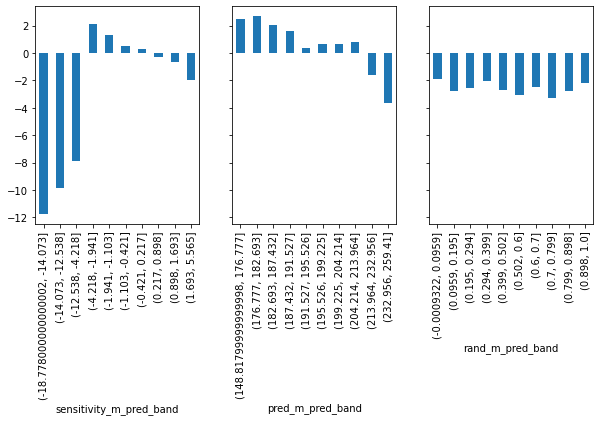

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)


D'abord, regardons le modèle aléatoire (`rand_m`). Il présente une sensibilité estimée à peu près égale dans chacune de ses partitions. On peut déjà voir en regardant le graphique qu'il ne nous aidera pas beaucoup en termes de personnalisation, car il ne peut pas distinguer les jours à haute sensibilité au prix des jours à basse sensibilité. Ensuite, considérons le modèle prédictif, `pred_m`. Ce modèle est en réalité prometteur ! Il parvient à construire des groupes où la sensibilité est élevée et d'autres où la sensibilité est faible. C'est exactement ce dont nous avons besoin.

Enfin, le modèle causal `sensitivity_m` semble un peu étrange. Il identifie des groupes de très faible sensibilité, où faible signifie en fait une haute sensibilité au prix (les ventes diminueront beaucoup à mesure que nous augmentons les prix). Détecter ces jours à haute sensibilité au prix est très utile pour nous. Si nous savons quand ils se produisent, nous veillerons à ne pas continuer à augmenter les prix pendant ces types de jours. Le modèle causal identifie également certaines régions moins sensibles, ce qui lui permet de distinguer avec succès les hautes des basses sensibilités. Mais le classement n'est pas aussi bon que celui du modèle prédictif.

Alors, que devons-nous décider ? Lequel est le plus utile ? Le modèle prédictif ou le modèle causal ? Le modèle prédictif a un meilleur classement, mais le modèle causal peut mieux identifier les extrêmes. Le graphique de sensibilité par tranche est un bon premier test, mais il ne peut pas répondre précisément à la question de savoir quel modèle est meilleur. Nous devons passer à quelque chose de plus élaboré.

## Courbe de Sensibilité Cumulative

Considérons à nouveau l'exemple illustratif où le prix a été converti en un traitement binaire. Nous reprendrons à partir de là où nous nous sommes arrêtés, donc nous avions la sensibilité du traitement par tranche. Ce que nous pouvons faire ensuite est de classer les tranches selon leur sensibilité. Autrement dit, nous prenons le groupe le plus sensible et le plaçons en premier, le deuxième groupe le plus sensible en deuxième place, et ainsi de suite. Pour les modèles 1 et 3, aucun réordonnancement n'est nécessaire, car ils sont déjà classés. Pour le modèle 2, nous devons inverser le classement.

Une fois que nous avons les groupes classés, nous pouvons construire ce que nous appellerons la Courbe de Sensibilité Cumulative. Nous calculons d'abord la sensibilité du premier groupe ; puis celle du premier et du deuxième groupe, et ainsi de suite, jusqu'à ce que tous les groupes soient inclus. À la fin, nous calculerons simplement la sensibilité pour l'ensemble du dataset. Voici à quoi cela ressemblerait pour notre exemple illustratif.

![img](./data/img/evaluate-causal-models/cumm_elast.png)

Remarquez que le premier bin dans la sensibilité cumulative est simplement l'ATE du groupe le plus sensible selon ce modèle. De plus, pour tous les modèles, la sensibilité cumulative convergera vers le même point, qui est l'ATE pour l'ensemble du dataset.

Mathématiquement, nous pouvons définir la sensibilité cumulative comme la sensibilité estimée jusqu'à l'unité $k$.

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

Pour construire la courbe de sensibilité cumulative, nous exécutons la fonction ci-dessus de manière itérative sur le dataset pour produire la séquence suivante.

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

C'est une séquence très intéressante en termes d'évaluation du modèle car nous pouvons faire des déclarations de préférence à son sujet. Premièrement, un modèle est meilleur dans la mesure où

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

pour tout $k$ et $a>0$. En d'autres termes, si un modèle est bon pour classer la sensibilité, la sensibilité observée dans les $k$ premiers échantillons devrait être plus élevée que la sensibilité observée dans les $k+a$ échantillons. Autrement dit, si je regarde les unités en haut du classement, elles devraient avoir une sensibilité plus élevée que les unités en dessous d'elles.

Deuxièmement, un modèle est meilleur dans la mesure où

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

est le plus grand, pour tout $k$ et $a>0$. L'intuition est que non seulement nous voulons que la sensibilité des $k$ premières unités soit plus élevée que celle des unités en dessous d'elles, mais nous voulons que cette différence soit aussi grande que possible.

Pour rendre cela plus concret, voici cette idée représentée en code.

In [10]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

Quelques éléments à noter concernant cette fonction. Elle suppose que l'élément ayant ordonné la sensibilité est stocké dans la colonne passée en argument `prediction`. De plus, le premier groupe a un nombre d'unités défini par `min_periods`, ce qui peut le rendre différent des autres. La raison en est qu'en raison de la petite taille de l'échantillon, la sensibilité peut être trop bruitée au début de la courbe. Pour remédier à cela, nous pouvons passer un premier groupe déjà suffisamment grand. Enfin, l'argument `steps` définit combien d'unités supplémentaires nous incluons dans chaque groupe suivant.

Avec cette fonction, nous pouvons désormais tracer la courbe de sensibilité cumulative, selon le classement produit par chacun de nos modèles.

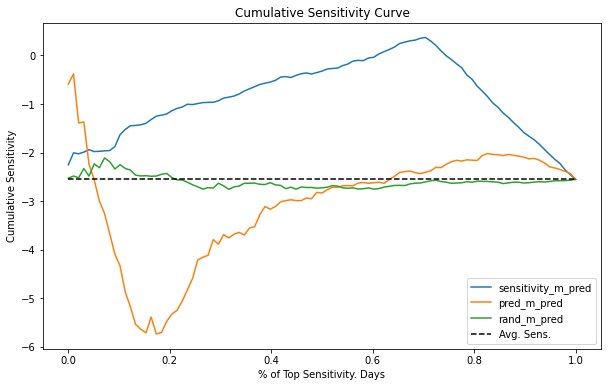

In [11]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

Interpréter une courbe de sensibilité cumulative peut être un peu difficile, mais voici comment je le vois. Encore une fois, il peut être plus facile de penser au cas binaire. L'axe des X de la courbe représente combien d'échantillons nous traitons. Ici, j'ai normalisé l'axe pour qu'il représente la proportion de l'ensemble de données, donc 0,4 signifie que nous traitons 40 % des échantillons. L'axe des Y est la sensibilité que nous devrions attendre pour ce nombre d'échantillons. Donc, si une courbe a une valeur de -1 à 40 %, cela signifie que la sensibilité des 40 % les plus élevés des unités est de -1. Idéalement, nous voulons la plus haute sensibilité pour l'échantillon le plus large possible. Une courbe idéale commencerait donc haut sur l'axe des Y et descendrait très lentement vers la sensibilité moyenne, représentant que nous pouvons traiter un pourcentage élevé d'unités tout en maintenant une sensibilité au-dessus de la moyenne.

Inutile de dire qu'aucun de nos modèles ne se rapproche de la courbe de sensibilité idéale. Le modèle aléatoire `rand_m` oscille autour de la sensibilité moyenne et ne s'éloigne jamais beaucoup de celle-ci. Cela signifie que le modèle ne peut pas trouver des groupes où la sensibilité est différente de la moyenne. Quant au modèle prédictif `pred_m`, il semble ordonner la sensibilité de manière inversée, car la courbe commence en dessous de la sensibilité moyenne. Non seulement cela, mais elle converge également rapidement vers la sensibilité moyenne, autour de 50 % des échantillons. Enfin, le modèle causal `sensitivity_m` semble plus intéressant. Il a ce comportement étrange au début, où la sensibilité cumulative s'éloigne de la moyenne, mais ensuite il atteint un point où nous pouvons traiter environ 75 % des unités tout en maintenant une sensibilité assez décente, presque nulle. Cela se produit probablement parce que ce modèle peut identifier les jours de très faible sensibilité (haute sensibilité au prix). Ainsi, tant que nous n'augmentons pas les prix ces jours-là, nous pouvons le faire pour la majorité de l'échantillon (environ 75 %), tout en ayant une faible sensibilité au prix.

En termes d'évaluation des modèles, la courbe de sensibilité cumulative est déjà beaucoup meilleure que la simple idée de sensibilité par tranche. Ici, nous avons réussi à faire des déclarations de préférence sur nos modèles qui étaient beaucoup plus précises. Cependant, c'est une courbe compliquée à comprendre. Pour cette raison, nous pouvons faire une amélioration supplémentaire.

## Courbe de Gain Cumulative

L'idée suivante est une amélioration très simple, mais puissante, de la sensibilité cumulative. Nous allons multiplier la sensibilité cumulative par la taille proportionnelle de l'échantillon. Par exemple, si la sensibilité cumulative est, disons -0,5 à 40 %, nous obtiendrons -0,2 (-0,5 * 0,4) à ce point. Ensuite, nous comparerons cela avec la courbe théorique produite par un modèle aléatoire. Cette courbe sera en réalité une ligne droite allant de 0 à l'effet moyen de traitement (ATE). Pensez-y de cette manière : chaque point de la sensibilité cumulative d'un modèle aléatoire est l'ATE, car le modèle produit simplement des partitions représentatives aléatoires des données. Si, à chaque point le long de la ligne (0,1), nous multiplions l'ATE par ce point, nous obtiendrons une ligne droite entre zéro et l'ATE.

![img](./data/img/evaluate-causal-models/cumm_gain.png)

Une fois que nous avons la courbe aléatoire théorique, nous pouvons l'utiliser comme référence et comparer nos autres modèles par rapport à elle. Toutes les courbes commenceront et se termineront au même point. Cependant, plus le modèle est efficace pour classer la sensibilité, plus la courbe s'écartera de la ligne aléatoire aux points situés entre zéro et un. Par exemple, dans l'image ci-dessus, M2 est meilleur que M1 car il s'écarte davantage avant d'atteindre l'ATE au point final. Pour ceux qui sont familiers avec la courbe ROC, vous pouvez considérer le Gain Cumulatif comme la ROC pour les modèles causaux.

Mathématiquement, 

$$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$$

Pour l'implémenter en code, il suffit d'ajouter la normalisation par la taille proportionnelle de l'échantillon.

In [12]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

Pour nos données des glaces, nous obtenons les courbes suivantes:

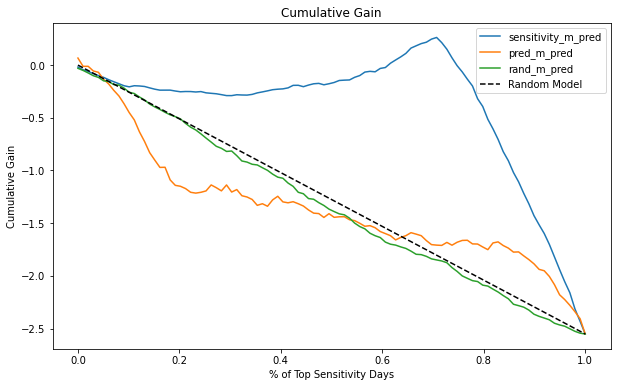

In [13]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

Il est maintenant très clair que le modèle causal (`sensitivity_m`) est bien meilleur que les deux autres. Il s'écarte beaucoup plus de la ligne aléatoire que `rand_m` et `pred_m`. De plus, notez comment le modèle aléatoire réel suit de très près le modèle aléatoire théorique. La différence entre les deux est probablement simplement due au bruit aléatoire.

Avec cela, nous avons couvert de très bonnes idées pour évaluer les modèles causaux. Rien que cela est une grande avancée. Nous avons réussi à évaluer la qualité des modèles en termes de classement de la sensibilité même si nous n'avions pas de vérité de base pour comparer. Il ne manque plus qu'une dernière chose : inclure un intervalle de confiance autour de ces mesures. Après tout, nous ne sommes pas des barbares, n'est-ce pas ?

![img](./data/img/evaluate-causal-models/uncivilised.png)

## Prendre en Compte la Variance

Il semble évident qu'il est nécessaire de prendre en compte la variance lorsque nous traitons des courbes de sensibilité. D'autant plus que tous utilisent la théorie de la régression linéaire, il devrait donc être relativement facile d'ajouter un intervalle de confiance autour d'elles.

Pour ce faire, nous allons d'abord créer une fonction qui retourne l'IC pour un paramètre de régression linéaire. J'utilise ici la formule pour la régression linéaire simple, mais n'hésitez pas à extraire l'IC comme vous le souhaitez.

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

In [14]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

Avec quelques modifications mineures de notre fonction `cumulative_sensitivity_curve`, nous pouvons obtenir l'intervalle de confiance pour la sensibilité.

In [15]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

Et enfin, voici la courbe de sensibilité cumulative avec l'intervalle de confiance à 95 % pour le modèle causal.

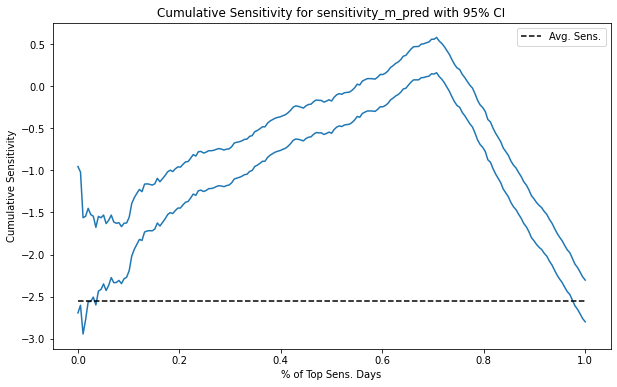

In [16]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

Notez comment l'intervalle de confiance se rétrécit de plus en plus à mesure que nous accumulons davantage de données. C'est parce que la taille de l'échantillon augmente.

Pour la courbe de Gain Cumulative, il est également très simple d'obtenir l'intervalle de confiance. Encore une fois, il suffit de remplacer un appel à la fonction `sensitivity` par un appel à la fonction `sensitivity_ci`.

In [17]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

Voici à quoi cela ressemble pour le modèle causal. Notez que maintenant, l'intervalle de confiance commence petit, même si la taille de l'échantillon est plus réduite au début de la courbe. La raison en est que le facteur de normalisation $\frac{k}{N}$ rétrécit le paramètre de l'ATE et son intervalle de confiance en même temps. Étant donné que cette courbe doit être utilisée pour comparer les modèles, cela ne devrait pas poser de problème, car la courbe appliquera ce facteur de réduction de manière égale à tous les modèles évalués.

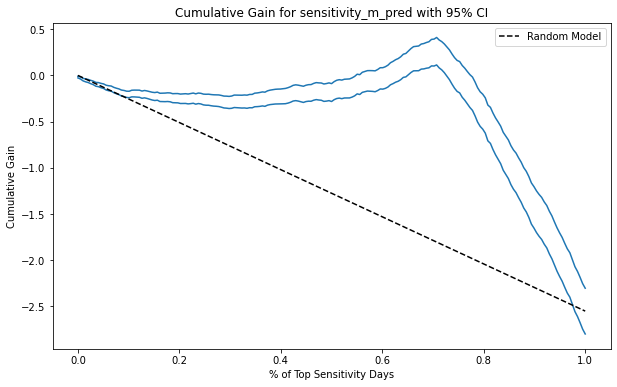

In [18]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();

## Idées Clés

Nous avons exploré trois méthodes pour évaluer la qualité d'un modèle en termes de classement de la sensibilité. Nous avons utilisé ces méthodes pour comparer et décider entre des modèles ayant un objectif causal. C'est une avancée majeure. Nous avons réussi à vérifier si un modèle est bon pour identifier des groupes avec des sensibilités différentes, même sans être capable de voir directement la sensibilité !

Ici, nous nous sommes largement appuyés sur des données aléatoires. Nous avons formé le modèle sur des données non aléatoires, mais toute l'évaluation a été réalisée sur un échantillon où le traitement a été randomisé. Cela est nécessaire pour estimer la sensibilité avec confiance. Sans données aléatoires, les formules simples que nous avons utilisées ici ne fonctionneraient pas. Comme nous le savons très bien maintenant, la régression linéaire simple présente un biais de variable omise en présence de variables de confusion.

Néanmoins, si nous pouvons obtenir des données aléatoires, nous savons déjà comment comparer les modèles aléatoires. Dans le prochain chapitre, nous aborderons le problème des données non aléatoires, mais avant cela, je voulais dire quelques mots sur l'évaluation des modèles.

Rappelons l'importance de l'évaluation fiable des modèles. Avec la courbe de gain cumulative, nous avons enfin un bon moyen de comparer les modèles utilisés pour l'inférence causale. Nous pouvons maintenant décider quel modèle est le meilleur pour la personnalisation des traitements. C'est un enjeu majeur. La plupart des matériaux que vous trouverez en inférence causale ne nous offrent pas de bonne méthode pour l'évaluation des modèles. À mon avis, c'est le maillon manquant pour rendre l'inférence causale aussi populaire que le machine learning. Avec une bonne évaluation, nous pouvons rapprocher l'inférence causale du paradigme train-test qui a déjà été si utile pour les modèles prédictifs. C'est une déclaration audacieuse. Ce qui signifie que je suis prudent lorsque je le dis, mais jusqu'à présent, je n'ai pas trouvé de critique valable à ce sujet. Si vous en avez, merci de me le faire savoir.

## Références

Les choses que j'ai écrites ici viennent principalement de ma propre expérience. Je les ai apprises par la pratique. Cela signifie qu'il n'y a pas de référence directe à laquelle je peux vous renvoyer. Cela signifie aussi que ce que j'ai écrit ici n'a **pas** été soumis à l'examen académique que la bonne science traverse souvent. Au lieu de cela, remarquez comment je parle de choses qui fonctionnent dans la pratique, mais je ne passe pas trop de temps à expliquer pourquoi cela est le cas. C'est une sorte de science de la rue, si vous voulez. Cependant, je mets cela à la disposition du public pour examen, donc, si vous trouvez quelque chose d'absurde, ouvrez un problème et je le traiterai au mieux de mes efforts.

J'ai tiré les idées de ce chapitre d'un article de Pierre Gutierrez et Jean-Yves Gérardy intitulé *Causal Inference and Uplift Modeling: A Review of the Literature*. Les auteurs y expliquent le concept de la courbe de Qini. Si vous recherchez cela, vous découvrirez qu'il s'agit d'une technique utilisée pour la modélisation de l'élévation, que vous pouvez considérer comme une inférence causale lorsque le traitement est binaire. Ici, j'ai pris l'idée de la courbe de Qini et je l'ai généralisée au cas de traitement continu. Je pense que les méthodes présentées ici fonctionnent pour les cas continus et binaires, mais encore une fois, je ne les ai vues nulle part ailleurs, donc gardez cela à l'esprit.

Je recommande également fortement de lire l'article de Leo Breiman (2001) sur le paradigme train-test : *Statistical Modeling: The Two Cultures*. C'est une excellente ressource si vous souhaitez comprendre ce qui rend une technique statistique réussie.

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).